### 2 - PRE - PROCESSAMENTO - BAG OF WORDS, VETORIZAÇÃO E SELEÇÃO DE CARACTERÍSTICAS

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
# CARREGANDO ARQUIVO
df_content_binario = pd.read_csv('df-content-binario.csv')

####  BAG OF WORDS E VETORIZAÇÃO: COUNT VECTORIZER

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from joblib import dump, load

In [5]:
# CRIANDO BAG OF WORDS
count_vectorizer = CountVectorizer(ngram_range = (1,1))
matriz = count_vectorizer.fit_transform(df_content_binario.passo6)

In [6]:
variaveis = count_vectorizer.get_feature_names()
variaveis[:20] # VISUALIZAR AS 20 PRIMEIRAS VARIÁVEIS

['ab',
 'abacate',
 'abache',
 'abachei',
 'abagem',
 'abaicha',
 'abaixar',
 'abaju',
 'abajur',
 'abalar',
 'abanar',
 'abandoba',
 'abandonar',
 'abandonoram',
 'abar',
 'abastecer',
 'abastecimento',
 'abater',
 'abatery',
 'abatimento']

In [7]:
vocabulario = count_vectorizer.vocabulary_
dict(list(vocabulario.items())[:20]) # VISUALIZAR AS 20 PRIMEIRAS PALAVRAS DO VOCABULÁRIO

{'promocao': 21314,
 'cartao': 4035,
 'anuidade': 1218,
 'enviar': 9884,
 'email': 9182,
 'tentar': 25650,
 'fazer': 11397,
 'comprar': 5255,
 'nao': 17587,
 'conseguir': 5725,
 'liquidificador': 15526,
 'utilizar': 26842,
 'restar': 23205,
 'desinstalar': 7652,
 'app': 1455,
 'verdadeiramente': 27231,
 'piar': 19990,
 'preco': 20741,
 'exorbitante': 10912,
 'produto': 21201}

In [8]:
print(matriz[0:10].toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [9]:
matriz.shape

(211593, 28123)

### 3 - SELEÇÃO DE VARIÁVEIS

In [10]:
from sklearn.feature_selection import SelectKBest, chi2

In [11]:
# SELEÇÃO DE K VARIÁVEIS
selectkbest = SelectKBest(chi2, k = 20000)
selectkbest.fit_transform(matriz, df_content_binario.sentimento)

<211593x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 1892257 stored elements in Compressed Sparse Row format>

In [12]:
# EXTRAÇÃO DO ÍNDICE DE COLUNA DAS MELHORES VARIÁVEIS
indices = selectkbest.get_support(indices = True)

In [13]:
# CRIAÇÃO DE UMA LISTA COM O NOME DAS MELHORES VARIÁVEIS 
melhores_variaveis = [variaveis[x] for x in indices]
melhores_variaveis[0:10]

['abacate',
 'abaixar',
 'abajur',
 'abanar',
 'abandonar',
 'abar',
 'abastecer',
 'abastecimento',
 'abatimento',
 'abelhar']

In [14]:
# CRIAÇÃO DE UMA LISTA COM AS VARIÁVEIS DO VOCABULÁRIO INICIAL
variaveis_iniciais = [i for i in vocabulario]

In [15]:
# CRIAÇÃO DE UMA LISTA PARA DESCARTE DAS VARIÁVEIS IRRELEVANTES
variaveis_descarte = [x for x in variaveis_iniciais if x not in melhores_variaveis]

In [16]:
# CRIAÇÃO DE UM NOVO COUNT VECTORIZER APÓS SELEÇÃO DE VARIÁVEIS
count_vectorizer_customizado = CountVectorizer(ngram_range = (1,1), stop_words = variaveis_descarte)
matriz_customizada = count_vectorizer_customizado.fit_transform(df_content_binario.passo6)

In [17]:
# SALVAR MODELO COUNT VECTORIZER
dump(count_vectorizer_customizado, 'count-vectorizer.pkl')

['count_vectorizer.pkl']

### 4 - DIVISÃO DADOS DE TREINO E TESTE

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

In [19]:
# SEPARAÇÃO BASE TREINO E TESTE 
xtreino, xteste, ytreino, yteste = train_test_split(df_content_binario.passo6, df_content_binario.sentimento, train_size = 0.7, random_state = 1)

In [20]:
# SALVAR OS DADOS DE TREINO E TESTE
xtreino.to_csv('xtreino.csv', index = False) 
xteste.to_csv('xteste.csv', index = False) 
ytreino.to_csv('ytreino.csv', index = False) 
yteste.to_csv('yteste.csv', index = False) 

In [21]:
# CARREGANDO DADOS DE TREINO E TESTE
xtreino = pd.read_csv('xtreino.csv')
xteste = pd.read_csv('xteste.csv') 
ytreino = pd.read_csv('ytreino.csv') 
yteste = pd.read_csv('yteste.csv') 

In [22]:
ytreino = np.ravel(ytreino)
yteste = np.ravel(yteste)

In [23]:
yteste

array(['negativo', 'positivo', 'negativo', ..., 'positivo', 'positivo',
       'negativo'], dtype=object)

In [24]:
count_vectorizer_customizado = load('count-vectorizer.pkl')

In [25]:
# APLICAR O COUNT VECTORIZED
xtreino = count_vectorizer_customizado.transform(xtreino.passo6)
xteste = count_vectorizer_customizado.transform(xteste.passo6)

In [26]:
xtreino

<148115x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 1321882 stored elements in Compressed Sparse Row format>

In [27]:
xteste

<63478x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 570375 stored elements in Compressed Sparse Row format>

### 5 - APRENDIZADO

In [28]:
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

#### DECISION TREE

In [ ]:
# TREINO
inicio = time.time()
dtree = DecisionTreeClassifier()

kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
param_grid1 = {"criterion": ["gini","entropy"],
               "random_state": [1]}

# GRID SEARCH
grid1 = GridSearchCV(estimator = dtree, 
                     param_grid = param_grid1, 
                     scoring = 'accuracy',
                     n_jobs = None,
                     refit = True,
                     cv = kfold, 
                     verbose = 1,
                     return_train_score = True)

dtreeCV = grid1.fit(xtreino, ytreino)

ac1 = dtreeCV.best_score_
print(f"Acurácia: {round(ac1*100, 2)}%")
fim = time.time()
print(f"Tempo de treino: {round((fim - inicio)/60, 2)} minutos")
print("\nMelhores hiperparâmetros: ", dtreeCV.best_params_)

In [29]:
# CARREGAR MODELO
dtreeCV = load('dtreeCV.pkl')

In [30]:
dtreeCV.best_params_

{'criterion': 'entropy', 'random_state': 1}

Acurácia Teste Decision Tree Unigrama-CV: 90.23%
Tempo de teste: 0.0 minutos

Relatório:

              precision    recall  f1-score   support

    positivo       0.89      0.91      0.90     31558
    negativo       0.91      0.89      0.90     31920

    accuracy                           0.90     63478
   macro avg       0.90      0.90      0.90     63478
weighted avg       0.90      0.90      0.90     63478



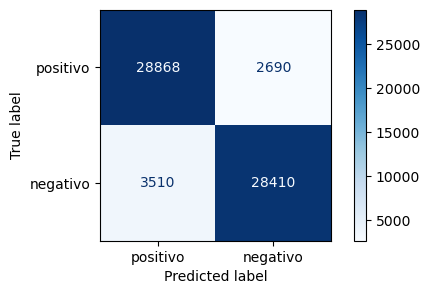

In [31]:
# TESTE
inicio = time.time()
prev_dtreeCV = dtreeCV.predict(xteste)
ac_dtreeCV = accuracy_score(prev_dtreeCV, yteste)
print(f"Acurácia Teste Decision Tree Unigrama-CV: {round(ac_dtreeCV*100, 2)}%")
fim = time.time()
print(f"Tempo de teste: {round((fim - inicio)/60, 2)} minutos\n\nRelatório:\n")
print(classification_report(yteste, prev_dtreeCV, labels = ["positivo", "negativo"]))
fig, axes = plt.subplots(figsize = (6, 3))
plot_confusion_matrix(dtreeCV, xteste, yteste, labels= ["positivo", "negativo"], values_format = 'd', cmap = 'Blues', ax = axes)
plt.savefig('cm-dtreeCV.png', format ='png', bbox_inches = 'tight')
plt.show()

In [32]:
# SALVAR MODELO
dump(dtreeCV, "dtreeCV.pkl")

['dtreeCV.pkl']

#### K-NEAREST NEIGHBOR

In [ ]:
# TREINO
inicio = time.time()
knn = KNeighborsClassifier()

kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
param_grid2 = {"n_neighbors": [5,9,15,25,35],
               "weights": ["uniform"],
               "algorithm": ["auto"],
               "leaf_size": [30],
               "p": [2],
               "metric": ["minkowski"]}

# GRID SEARCH
grid2 = GridSearchCV(estimator = knn, 
                     param_grid = param_grid2, 
                     scoring = 'accuracy',
                     n_jobs = None,
                     refit = True,
                     cv = kfold, 
                     verbose = 1,
                     return_train_score = True)

knnCV = grid2.fit(xtreino, ytreino)

ac2 = knnCV.best_score_
print(f"Acurácia: {round(ac2*100, 2)}%")
fim = time.time()
print(f"Tempo de treino: {round((fim - inicio)/60, 2)} minutos")
print("\nMelhores hiperparâmetros: ", knnCV.best_params_)

In [33]:
# CARREGAR MODELO
knnCV = load('knnCV.pkl')

In [34]:
knnCV.best_params_

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Acurácia Teste KNN Unigrama-CV: 89.71%
Tempo de teste: 6.48 minutos

Relatório:

              precision    recall  f1-score   support

    positivo       0.87      0.94      0.90     31558
    negativo       0.93      0.86      0.89     31920

    accuracy                           0.90     63478
   macro avg       0.90      0.90      0.90     63478
weighted avg       0.90      0.90      0.90     63478



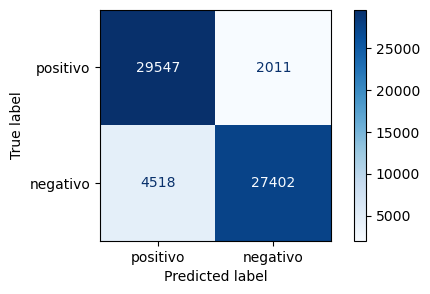

In [35]:
# TESTE
inicio = time.time()
prev_knnCV = knnCV.predict(xteste)
ac_knnCV = accuracy_score(prev_knnCV, yteste)
print(f"Acurácia Teste KNN Unigrama-CV: {round(ac_knnCV*100, 2)}%")
fim = time.time()
print(f"Tempo de teste: {round((fim - inicio)/60, 2)} minutos\n\nRelatório:\n")
print(classification_report(yteste, prev_knnCV, labels = ["positivo", "negativo"]))
fig, axes = plt.subplots(figsize = (6, 3))
plot_confusion_matrix(knnCV, xteste, yteste, labels = ["positivo", "negativo"], values_format = 'd', cmap = 'Blues', ax = axes)
plt.savefig('cm-knnCV.png', format ='png', bbox_inches = 'tight')
plt.show()

In [36]:
# SALVAR MODELO
dump(knnCV, "knnCV.pkl")

['knnCV.pkl']

#### NAIVE BAYES

In [ ]:
# TREINO
inicio = time.time()
nb = MultinomialNB()

kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
param_grid3 = {"alpha": [1.0],
               "fit_prior": [True],
               "class_prior": [None]}
# GRID SEARCH
grid3 = GridSearchCV(estimator = nb,
                     param_grid = param_grid3,
                     scoring = 'accuracy',
                     n_jobs = None,
                     refit = True,
                     cv = kfold, 
                     verbose = 1,
                     return_train_score = True)

nbCV = grid3.fit(xtreino, ytreino)


ac3 = nbCV.best_score_
print(f"Acurácia: {round(ac3*100, 2)}%")
fim = time.time()
print(f"Tempo de treino: {round((fim - inicio)/60, 2)} minutos")
print("\nMelhores hiperparâmetros: ", nbCV.best_params_)

In [37]:
# CARREGAR MODELO
nbCV = load('nbCV.pkl')

Acurácia Teste Naive Bayes Unigrama-CV: 93.12%
Tempo de teste: 0.01 minutos

Relatório:

              precision    recall  f1-score   support

    positivo       0.94      0.92      0.93     31558
    negativo       0.93      0.94      0.93     31920

    accuracy                           0.93     63478
   macro avg       0.93      0.93      0.93     63478
weighted avg       0.93      0.93      0.93     63478



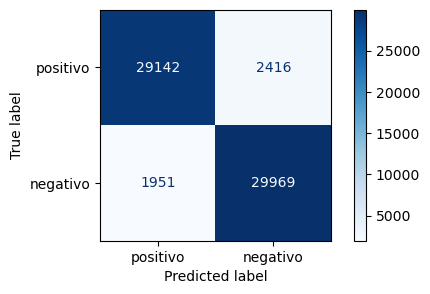

In [38]:
# TESTE
inicio = time.time()
prev_nbCV = nbCV.predict(xteste)
ac_nbCV = accuracy_score(prev_nbCV, yteste)
print(f"Acurácia Teste Naive Bayes Unigrama-CV: {round(ac_nbCV*100, 2)}%")
fim = time.time()
print(f"Tempo de teste: {round((fim - inicio)/60, 2)} minutos\n\nRelatório:\n")
print(classification_report(yteste, prev_nbCV, labels = ["positivo", "negativo"]))
fig, axes = plt.subplots(figsize = (6, 3))
plot_confusion_matrix(nbCV, xteste, yteste, labels = ["positivo", "negativo"], values_format = 'd', cmap = 'Blues', ax = axes)
plt.savefig('cm-nbCV.png', format ='png', bbox_inches = 'tight')
plt.show()

In [39]:
# SALVAR MODELO
dump(nbCV, 'nbCV.pkl')

['nbCV.pkl']

#### XTREME GRADIENT BOOSTING

In [40]:
# FUNÇÃO PARA TRANSFORMAÇÃO DAS CLASSES
def TransformaClasse(array):
    
    for i in range(len(array)):
        if array[i] == "negativo":
            array[i] = 1
        else:
            array[i] = 0
    return(array)

In [41]:
ytreino_transf = TransformaClasse(ytreino)
ytreino_xgb = [value for value in ytreino_transf]

In [42]:
yteste_transf = TransformaClasse(yteste)
yteste_xgb = [value for value in yteste_transf]

In [ ]:
# max_depth=5, 
# learning_rate=0.01, 
# n_estimators=100, 
# gamma=0, 
# min_child_weight=1, 
# subsample=0.8
# colsample_bytree=0.8, 
# reg_alpha=0.005
#eval_metric=["error"]

#xgbCV = grid5.fit(xtreino, ytreino_xgb, eval_set = [(xtreino, ytreino_xgb)])

In [ ]:
# TREINO
inicio = time.time()
xgb_cl = XGBClassifier()

kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
param_grid5 = {"n_estimators": [100,300,700,1000,1100],
               "learning_rate": [0.01,0.2,0.3],
               "gamma": [0.2],
               "max_depth": [6],
               "subsample": [0.7],      
               "colsample_bytree": [0.7],
               "reg_alpha": [0.05],
               "objective": ["binary:logistic"]}

# GRID SEARCH
grid5 = GridSearchCV(estimator = xgb_cl, 
                     param_grid = param_grid5, 
                     scoring = "accuracy",
                     n_jobs = None,
                     refit = True,
                     cv = kfold, 
                     verbose = 1,
                     return_train_score = True)


xgbCV = grid5.fit(xtreino, ytreino_xgb)

ac5 = xgbCV.best_score_
print(f"Acurácia: {round(ac5*100, 2)}%")
fim = time.time()
print(f"Tempo de treino: {round((fim - inicio)/60, 2)} minutos")
print("\nMelhores hiperparâmetros: ", xgbCV.best_params_)

In [43]:
# CARREGAR MODELO
xgbCV = load('xgbCV.pkl')

In [44]:
xgbCV.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.2,
 'learning_rate': 0.2,
 'max_depth': 6,
 'n_estimators': 1100,
 'objective': 'binary:logistic',
 'reg_alpha': 0.05,
 'subsample': 0.7}

Acurácia Teste XGBoost Unigrama-CV: 93.8
AUC XGBoost Unigrama-CV: 0.9787
Tempo de teste: 0.09 minutos

Relatório:

              precision    recall  f1-score   support

    positivo       0.94      0.94      0.94     31558
    negativo       0.94      0.94      0.94     31920

    accuracy                           0.94     63478
   macro avg       0.94      0.94      0.94     63478
weighted avg       0.94      0.94      0.94     63478



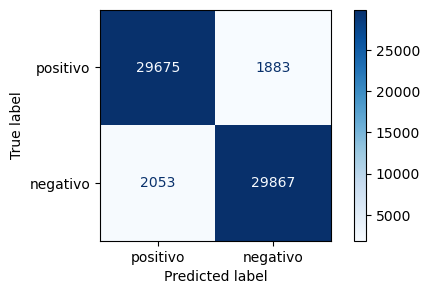

In [45]:
inicio = time.time()
prev_xgbCV = xgbCV.predict(xteste)
ac_xgbCV = accuracy_score(yteste_xgb, prev_xgbCV)
auc = roc_auc_score(yteste_xgb, xgbCV.predict_proba(xteste)[:, 1])
print(f"Acurácia Teste XGBoost Unigrama-CV: {round(ac_xgbCV*100, 2)}")
print(f"AUC XGBoost Unigrama-CV: {round(auc, 4)}")
fim = time.time()
print(f"Tempo de teste: {round((fim - inicio)/60, 2)} minutos\n\nRelatório:\n")
print(classification_report(yteste_xgb, prev_xgbCV, target_names = ["positivo", "negativo"]))
fig, axes = plt.subplots(figsize = (6, 3))
plot_confusion_matrix(xgbCV, xteste, yteste_xgb, display_labels = ["positivo", "negativo"], values_format = 'd', cmap = 'Blues', ax = axes)
plt.savefig('cm-xgbCV.png', format ='png', bbox_inches = 'tight')
plt.show()

In [46]:
# SALVAR MODELO
dump(xgbCV, "xgbCV.pkl")

['xgbCV.pkl']